In [ ]:
#Import all necessary libraries and packages
import numpy as np
import math
import scipy as sp
import random
from sklearn import neighbors
from mpl_toolkits.mplot3d import axes3d, Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

This project is a numerical application of a soon-to-be released paper in collaboration with Martin Andersson, Benny Avelin, Paulina Ilmonen and Lauri Viitasaari. We consider a partial differential equation with a stochastic perturbation (neal life example would be a measurement noise) and the goal is to build a data-driven estimator of the noise. 

We consider a Stochastic partial differential equation of the type

\begin{equation}\label{SPDE}
    \begin{cases}
      -Lu(t,x)+\sigma(u(t,x))\dot W(t,x)=0\\
      u(\cdot,0)=u_0,\\
    \end{cases}       
\end{equation}

where $t$ is the time parameter, $x\in\mathbb{R}^d$ and $L$ is a second order differential operator and $W$ is a stochastic perturbation. Typical example (studied here): 1 dimensional stochastic heat equation with space time white noise $W$:

\begin{equation}
    \begin{cases}
      -\partial_tu(t,x)+\partial^2_xu(t,x)+\sigma(u(t,x))\dot W(t,x)=0\\
      u(\cdot,0)=u_0.\\
    \end{cases}       
\end{equation}

**Goal: Estimate the (functional) amplitude $\sigma^2$ of the noise.**

**Result: Under reasonable assumption, we show that the following estimator converges to $\sigma^2(u(t_0,x_0))$ for all $x_0,t_0$:**

\begin{eqnarray}\label{mainEstimator}
&&\Sigma_{\epsilon, h}(x_0,t_0)
:=\mathbb{E}_{u(t_0,x_0)}\left[\left(\frac{1}{m(\epsilon)}\int_{\mathcal{B}_{x_0,\epsilon}}\int_{t_0}^{t_0+\epsilon}
\left(L^hu(s,y)-\int_{\mathbb{R}^d}L^hG(s,y-z)u_0(z)dz\right)dsdy\right)^2\right],\notag\\
\end{eqnarray}

where $\epsilon\rightarrow 0$, $h<<\epsilon^2$, $L^h$ is the discretisation of the diffential operator and $\mathbb{E}_{u(t_0,x_0)}$ is the conditional expectation given $u(t_0,x_0)$. In the particular case we study here, $m(\epsilon)=2\epsilon$ and $\mathcal{B}_{x_0,\epsilon}=[x_0-\epsilon,x_0+\epsilon]$.

This methodology is illustrated below.

The first step is to simulate the solution to the stochastic heat equation equation, which we do in the next cell according to the methodology described in https://www.math.chalmers.se/~cohend/Recherche/cohenquerR.pdf
We simulate the solution on $[0,1]\times[0,T]$

In [3]:
#Two possibilities: white noise increments or white in time/coloured in space (with Riesz correlation)
#M=space discretization parameter
#N=time discretization parameter
#Only one dimension for now


def SpaceTimeWhiteNoise(M,N,a,b,T):
    M1=int(np.floor((b-a)*M))
    N1=int(np.floor(T*N))
    W=np.random.normal(loc=0.0, scale=1.0, size=(M1-1,N1))
    return (1/np.sqrt(N))*W

def expIntegrator(M,N,a,b):
    M1=int(np.floor((b-a)*M))
    E=np.zeros((M1-1,M1-1))
    A=np.zeros((M1-1,M1-1))
    for i in range(M1-1):
        A[i,i]=-1
        if i>0:
            A[i,i-1]=0.5
        if i<M1-2:
            A[i,i+1]=0.5
    E=M*M/N*A
    E=sp.linalg.expm(E)
    return(E)

def PDEsolution(u0,M,N,a,b,T,f):
    M1=int(np.floor((b-a)*M))
    N1=int(np.floor(T*N))
    u=np.zeros((M1-1,N1+1))
    E=expIntegrator(M,N,a,b)
    u[:,0]=u0
    for i in range(1,N1+1):
        F=[f(x) for x in u[:,i-1]]
        u[:,i]=np.dot(E,u[:,i-1])+(1/N)*np.dot(E,F)
    return(u)

def SPDEsolution (u0,M,N,a,b,T,sigma,f):
    M1=int(np.floor((b-a)*M))
    N1=int(np.floor(T*N))
    W=SpaceTimeWhiteNoise(M,N,a,b,T)
    u=np.zeros((M1-1,N1+1))
    E=expIntegrator(M,N,a,b)
    u[:,0]=u0
    for i in range(1,N1+1):
        v=[math.sqrt(M)*sigma(u[j,i-1]) for j in range (M1-1)]
        Sigma=np.diag(v)
        L=np.dot(Sigma,W[:,i-1])
        F=[f(x) for x in u[:,i-1]]
        u[:,i]=np.dot(E,u[:,i-1])+(1/N)*np.dot(E,F)+np.dot(E,L)
    return(u)   

The following cell illustrate the effect of the stochastic perturbation on the shape of the solution. 
We use $\sigma=\sin$

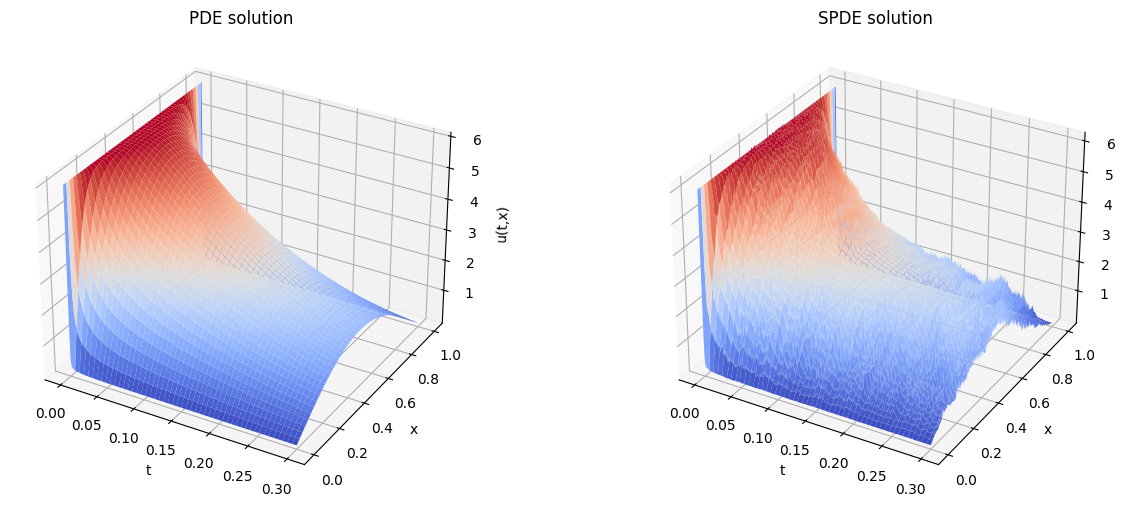

In [9]:
a=0
b=1
T=0.3
M=512
N=500000
N1=np.floor(N*T)
M1=np.floor(M*(b-a))
space=np.linspace(a,b,int(M1)-1)
time=np.linspace(0,T,int(N1)+1)
Time,Space=np.meshgrid(time,space)
u0=6*np.ones(M-1)
def sigma(x):
    return np.sin(x)
def f(x):
    return 0
 
v=SPDEsolution(u0,M,N,a,b,T,sigma,f)
u=PDEsolution(u0,M,N,a,b,T,f)

np.save("solution SPDE",v)
np.save("solution PDE",u)

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121, projection='3d')
    
ax1.plot_surface(Time, Space, u, cmap=cm.coolwarm,linewidth=3, antialiased=True)

ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_zlabel('u(t,x)')
ax1.title.set_text('PDE solution')
ax2 = fig.add_subplot(122, projection='3d')
    
ax2.plot_surface(Time, Space, v, cmap=cm.coolwarm,linewidth=3, antialiased=True)



ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_zlabel('v(t,x)')
ax2.title.set_text('SPDE solution')

plt.show()   

As illustrated above, the stochastic perturbation does not modify the overall shape of the solution but add some small fluctuations on the surface.

In the following cell, we compute L_integrated as \begin{equation*}\left(\frac{1}{m(\epsilon)}\int_{\mathcal{B}_{x_0,\epsilon}}\int_{t_0}^{t_0+\epsilon}
\left(L^hu(s,y)-\int_{\mathbb{R}^d}L^hG(s,y-z)u_0(z)dz\right)dsdy\right)^2\end{equation*} for $t_0$ and $x_0$ in a list of point called list_tx. It is more practical to choose two discretiations $\epsilon_t,\epsilon_x$ and $h_t,h_x$, which does not cause issues as long as $h_t<<h_x^2$

Here $h_x=\frac{1}{M}$, $h_t=\frac{1}{N}$

In [10]:
#partial differential operator
def L(u,M,N):
    M1,N1=u.shape[0]+1,u.shape[1]-1
    Lu=np.zeros((M1-3,N1))
    for i in range(M1-3):
        for j in range(N1):
            Dt=N*(u[i+1,j+1]-u[i+1,j])
            Dxx=(1/2)*M*M*(u[i+2,j]-2*u[i+1,j]+u[i,j])
            Lu[i,j]=Dt-Dxx
    return Lu

def L_integrated(u,list_tx,epsilon_x,epsilon_t,M,N):
    factor=(1/math.sqrt(2*epsilon_x))*(1/math.sqrt(epsilon_t))
    num_points=list_tx.shape[1]
    Lu=L(u,M,N)
    listResults=np.zeros((2,num_points))
    total_t=int(math.floor(N*epsilon_t))
    total_x=int(math.floor(M*epsilon_x))
    for sample in range(list_tx.shape[1]):
        listResults[0,sample]=u[list_tx[0,sample],list_tx[1,sample]]
        
        subset=Lu[list_tx[0,sample]-total_x-1:list_tx[0,sample]+total_x-1,list_tx[1,sample]:list_tx[1,sample]+total_t]
        
        listResults[1,sample]=(factor*np.trapz(np.trapz(subset,dx=(1/N),axis=0),dx=(1/M),axis=0))**2
    return listResults

Next, we draw at random $k$ points on $[0,1]\times[0,T]$ to construct list_tx and compute the function L_integrated for each of them

In [18]:
def random_points(epsilon_x,epsilon_t,T,M,N,a,b,k):
    M1=math.floor((b-a)*M)
    N1=math.floor(N*T)
    total_t=int(math.floor(N*epsilon_t))
    total_x=int(math.floor(M*epsilon_x))
    min_x=total_x+1
    max_x=M1-3-total_x+1
    min_t=0
    max_t=N1-total_t
    x=np.arange(min_x,max_x,1)
    y=np.arange(min_t,max_t,1)
    X=np.random.choice(x, size=k, replace=True)
    Y=np.random.choice(y, size=k, replace=True)
    
    return np.vstack((X,Y))

In [19]:
epsilon_x=0.022
epsilon_t=0.0002
list_tx=random_points(epsilon_x,epsilon_t,T,M,N,a,b,50000)
z=L_integrated(v,list_tx,0.022,0.0002,M,N)

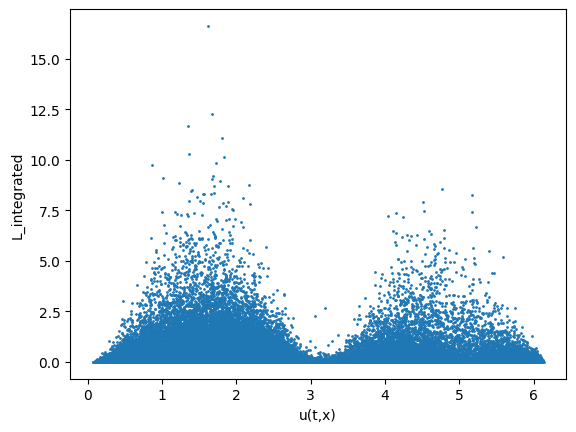

In [22]:
plt.xlabel('u(t,x)')
plt.ylabel('L_integrated')
plt.plot(z[0,:],z[1,:],marker='o',linestyle='None',markersize=1)

Finally, we need to compute the conditional expectation $\mathbb{E}_{t_0,x_0}$[L_integrated] to obtain the estimation of $sigma^2$

**Tricks:** the solution $u(t_0,x_0)$ is 'locally stationary'. As such, we can compute the conditional expectation by using the $k$-nearest neighbor regression (we use the neighbors package from scikit-learn). For a point $(x_0,t_0)$, the neighbors are the $k$ closest points in the list list_tx and the corresponding dependent variable is L_integrated

Results are displayed below for $\sigma=sin$, with $k=500$ and 50 000 points in list_tx

In [33]:
def Estimator(z,func,n_points,n_neighbors):
    low=min(z[0,:])
    high=max(z[0,:])
    points=np.linspace(high,low,n_points)[:, np.newaxis]
    knn = neighbors.KNeighborsRegressor(n_neighbors)
    u_points=z[0,:].reshape(-1, 1)
    result = knn.fit(u_points, z[1,:]).predict(points)
    plt.plot(points, result,label='estimator')
    
    plt.plot(points, (func(points))**2, label='sigma**2')
    plt.legend(loc='upper center')
    plt.show()

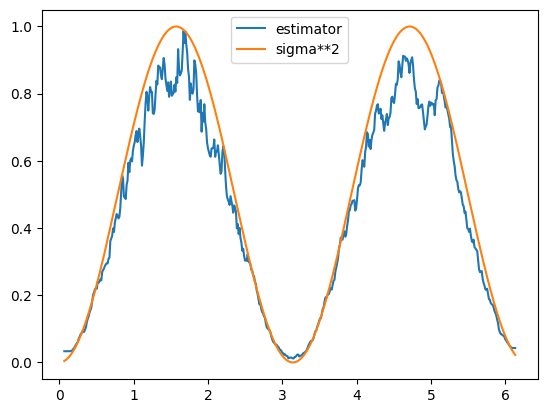

In [34]:
Estimator(z,sigma,500,500)
